In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from google.colab import drive
%matplotlib inline
from skimage import io, color
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow as tf  
from keras.utils import to_categorical
import glob
import re
from tensorflow.python.keras import applications
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

In [0]:
# mount drive on Google drive to access training data
# Ignore this if you don't use Google Colab
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Access training data in My Drive
train_path = "/content/drive/My Drive/ECE_542/TrainData-C2/"
# get training labels
train_labels = pd.read_csv("/content/drive/My Drive/ECE_542/TrainData-C2/TrainAnnotations.csv")
train_labels.sort_values(by=["file_name"], inplace=True)
train_files = glob.glob(train_path + "*.jpg")
train_files.sort()

# Helper functions

In [0]:
def extract_data(file_names, labels, size=None):
  """
  Extract all images given list of file names and list of labels.  Also resize
  images according to user-defined size
  Inputs:
  - filenames: list of file paths to images
  - labels: list of label of each image; order based on the order of filenames
  Outputs:
  - images: list of RGB images
  - annotations: list of labels for the images
  """
  images = []
  annotations = []
  for idx, f in enumerate(file_names):
    img = io.imread(f)
    if size is not None:
      img = resize(img, (size, size), anti_aliasing=True)
    images.append(img)
    annotations.append(labels[idx])
  return images, annotations

In [0]:
def RGB2HSV(images, hue=False):
  """
  Convert all RGB images into HSV channel
  Input:
  - images: list of images of shape (H, W, 3)
  """
  hsv = []
  for img in images:
    if hue:
      hsv.append(color.rgb2hsv(img)[:,:,0])
    else:
      hsv.append(color.rgb2hsv(img))
  return hsv

# Preparing data and training model

In [0]:
# This cell may take awhile to run
# extract all data
images, labels = extract_data(train_files, train_labels.annotation, 224)
# convert RGB into HSV
images = RGB2HSV(images, hue=True)

In [0]:
# Split training and validation test set
Y = to_categorical(labels)
X = np.array(images)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=32)

# prepare data for oversampling and undersampling
#n_train, H, W, C = X_train.shape  # dimension of training data
n_train, H, W = X_train.shape  # dimension of training data in hue space
n_val = len(X_val)  # number of samples in validation set
#X_train = np.reshape(X_train, (n_train, H*W*C))
#X_val = np.reshape(X_val, (n_val, H*W*C))
X_train = np.reshape(X_train, (n_train, H*W))
X_val = np.reshape(X_val, (n_val, H*W))

# oversampling the train set
oversample = SMOTE(random_state=32)
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

# undersampling the validation set
cc = ClusterCentroids(random_state=32)
X_val, Y_val = cc.fit_resample(X_val, Y_val)

# reshape training and validation data to prepare for training
#X_val = np.reshape(X_val, (len(X_val), H, W, C))
#X_train = np.reshape(X_train, (len(X_train), H, W, C))
X_val = np.reshape(X_val, (len(X_val), H, W, 1))
X_train = np.reshape(X_train, (len(X_train), H, W, 1))

# Checking the shape of training and validation data
print(X_val.shape)
print(X_train.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(190, 224, 224, 1)
(1675, 224, 224, 1)


In [0]:
# class distribution of training and validation sets
print(np.sum(Y_train, axis=0))
print(np.sum(Y_val, axis=0))

[335 335 335 335 335]
[38 38 38 38 38]


In [0]:
# create, compile and training resNet50 model
base_model = applications.resnet.ResNet50(weights=None, 
                                          include_top=False,
                                          input_shape=(224, 224, 1)) # 1 for HUE, 3 for HSV or RGB
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# compile model
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=sgd, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
# train model
history4 = model.fit(X_train, Y_train, 
                     epochs=15, 
                     batch_size=32,
                     validation_data=(X_val, Y_val))

Epoch 1/15
53/53 [==============================] - 125s 2s/step - loss: 4.5016 - accuracy: 0.2567 - val_loss: 204596.3125 - val_accuracy: 0.2000
Epoch 2/15
53/53 [==============================] - 124s 2s/step - loss: 4.2415 - accuracy: 0.2860 - val_loss: 220.4627 - val_accuracy: 0.2737
Epoch 3/15
53/53 [==============================] - 125s 2s/step - loss: 3.4071 - accuracy: 0.3087 - val_loss: 78.9013 - val_accuracy: 0.2000
Epoch 4/15
53/53 [==============================] - 125s 2s/step - loss: 2.6785 - accuracy: 0.3319 - val_loss: 19.1782 - val_accuracy: 0.2579
Epoch 5/15
53/53 [==============================] - 126s 2s/step - loss: 2.4332 - accuracy: 0.3648 - val_loss: 1.8648 - val_accuracy: 0.3211
Epoch 6/15
53/53 [==============================] - 127s 2s/step - loss: 2.0714 - accuracy: 0.3988 - val_loss: 1.5162 - val_accuracy: 0.3053
Epoch 7/15
53/53 [==============================] - 126s 2s/step - loss: 2.0806 - accuracy: 0.4018 - val_loss: 1.5462 - val_accuracy: 0.4000
Epoc

<Figure size 432x288 with 0 Axes>

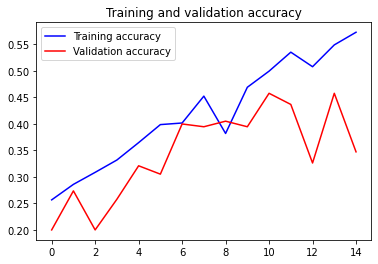

<Figure size 432x288 with 0 Axes>

In [0]:
# plot learning curves
accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

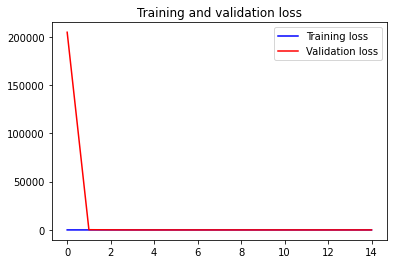

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

# Make prediction on test set

In [0]:
# Loading the test set
# Access testing data in My Drive
test_path = "/content/drive/My Drive/ECE_542/TestData/"
test_files = glob.glob(test_path + "*.jpg")
test_files.sort()

In [0]:
# Load all testing data and convert them into hsv 
test_data = []
for f in test_files:
  img = io.imread(f)
  # rescale images to half original size
  img = resize(img, (224, 224), anti_aliasing=True)
  #hsv = color.rgb2hsv(img)
  hue = color.rgb2hsv(img)[:,:,0]
  test_data.append(hue)

In [0]:
# making prediction
P = model.predict(np.array(test_data))
Yhat = np.argmax(P, axis=1)

In [0]:
# save result
# Taken from Homework2b
def vectorize_result(nclass, j):
    """
    Return a nclass-dimensional unit vector with 1.0 in the j-th position
    and zero elsewhere
    """
    e = np.zeros((nclass,1))
    e[j] = 1.0
    return e

In [0]:
encode = [vectorize_result(5, Yhat[i]) for i in range(Yhat.shape[0])]
pred_df = pd.DataFrame(np.array(encode).reshape((Yhat.shape[0], 5)).astype(np.uint8))
# Save predictions to csv
pred_df.to_csv("/content/drive/My Drive/ECE_542/prediction_final_hue.csv", header=False, index=False)

In [0]:
model.save("/content/drive/My Drive/ECE_542/resnet_SGD_final_hue.h5")